In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lib.envs.windy_gridworld import WindyGridworldEnv
from collections import defaultdict

In [85]:
env = WindyGridworldEnv()

In [86]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    '''

    :param Q: links state -> action value (dictionary)
    :param state: state character is in (int)
    :param nA: number of actions (int)
    :param epsilon: chance it will take a random move (float)
    :return:
    '''
    probs = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    probs[best_action] += 1.0 - epsilon

    return probs

In [87]:
def Q_learning(episodes, learning_rate, discount, epsilon):
    '''

    :param episodes: Number of episodes to run (int)
    :param learning_rate: How fast it will converge to a point (float [0, 1])
    :param discount: How much future events lose their value (float [0, 1])
    :param epsilon: chance a random move is selected (float [0, 1])
    :return: x,y points to graph
    '''

    # Links state to action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Points to plot
    # number of episodes
    x = np.arange(episodes)
    # Number of steps
    y = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()

        for step in range(10000):

            # Select and take action
            probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)

            # TD Update
            td_target = reward + discount * np.amax(Q[next_state])
            td_error = td_target - Q[state][action]
            Q[state][action] += learning_rate * td_error

            if done:
                y[episode] = step
                break

            state = next_state

    return x, y

In [88]:
def Q_learning_lambda(episodes, learning_rate, discount, epsilon, _lambda):
    '''

    :param episodes: Number of episodes to run (int)
    :param learning_rate: How fast it will converge to a point (float [0, 1])
    :param discount: How much future events lose their value (float [0, 1])
    :param epsilon: chance a random move is selected (float [0, 1])
    :param _lambda: How much credit to give states leading up to reward (float [0, 1])
    
    :return: x,y points to graph
    '''

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    e = defaultdict(lambda: np.zeros(env.action_space.n))
    x = np.arange(episodes)
    y = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()

        probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
        action = np.random.choice(len(probs), p=probs)

        for step in range(10000):
            next_state, reward, done, _ = env.step(action)

            probs = epsilon_greedy_policy(Q, next_state, env.action_space.n, epsilon)
            next_action = np.random.choice(len(probs), p=probs)

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]

            e[state][action] += 1

            for s in Q:
                for a in range(len(Q[s])):
                    Q[s][a] += learning_rate * td_error * e[s][a]
                    if next_action is best_next_action:
                        e[s][a] = discount * _lambda * e[s][a]
                    else:
                        e[s][a] = 0

            if done:
                y[episode] = step
                e.clear()
                break

            action = next_action
            state = next_state

    return x, y

In [89]:
episodes = 100
learning_rate = 0.5
discount = 0.9
epsilon = 0.05
_lambda = 0.5

In [90]:
x, y = Q_learning(episodes, learning_rate, discount, epsilon)
a, b = Q_learning_lambda(episodes, learning_rate, discount, epsilon, _lambda)

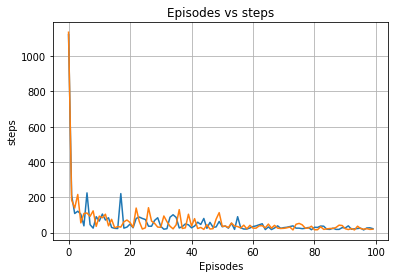

In [91]:
_, ax = plt.subplots()
ax.plot(x, y)
ax.plot(a, b)

ax.set(xlabel='Episodes', ylabel='steps',
       title='Episodes vs steps')
ax.grid()

plt.show()